# **Machine Translation - CSCE 636 Project**

## **Introduction**

The goal of this project is to implement a machine translation model. In the first step, a dataset of German to English terms will be used to train a translation model. The dataset can be accessed here:

[German-English deu-eng.zip](http://www.manythings.org/anki/deu-eng.zip)

## **Load the Dataset**

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Unzip the data file
import zipfile
zip_ref = zipfile.ZipFile('deu-eng.zip', 'r')
zip_ref.extractall('data-deu-eng')
zip_ref.close()

The file called deu.txt that contains 152,820 pairs of English to German phases, one pair per line with a tab separating the language.

In [4]:
# First 5 lines of the deu.txt file
import re
with open("data-deu-eng/deu.txt") as datafile:
    head = [next(datafile) for x in range(5)]

for pair in head:
  print(re.sub('\s+',' ',pair))

Hi. Hallo! 
Hi. Grüß Gott! 
Run! Lauf! 
Wow! Potzdonner! 
Wow! Donnerwetter! 


## **Prepare the Text Data**

Reviewing the raw data, there are some observations:
* Punctuation;
* Uppercase and lowercase; 
* Special characters in German; 
* Same phrases in English with different translations in German.

Therefore, it is necessary to clean the data. So the data preparation is divided into two subsections:
**clean text and split text**.

In [5]:
# load doc into memory
import string
from pickle import dump
from unicodedata import normalize
from numpy import array

def load_doc(filename):
	# open the file as read only
	file = open(filename, mode='rt', encoding='utf-8') # preserving the Unicode German characters
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

**1. Clean Text**

In [6]:
# split a loaded document into sentences
def to_pairs(doc):
	lines = doc.strip().split('\n')
	pairs = [line.split('\t') for line in  lines] # seperate the English and German phrases
	return pairs

In [7]:
# clean a list of lines
def clean_pairs(lines):
	cleaned = list()
  
	# prepare regex for char filtering
	re_print = re.compile('[^%s]' % re.escape(string.printable))
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for pair in lines:
		clean_pair = list()
		for line in pair:
			line = normalize('NFD', line).encode('ascii', 'ignore') # normalize unicode characters
			line = line.decode('UTF-8')
			line = line.split()
			line = [word.translate(table) for word in line]         # remove punctuation from each token
			line = [re_print.sub('', w) for w in line]              # remove non-printable chars form each token
			line = [word for word in line if word.isalpha()]        # remove tokens with numbers in them
			clean_pair.append(' '.join(line))
		cleaned.append(clean_pair)
	return array(cleaned)

In [8]:
# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)

# load dataset
filename = 'data-deu-eng/deu.txt'
doc = load_doc(filename)
pairs = to_pairs(doc)
clean_pairs = clean_pairs(pairs)

# save clean pairs to file
save_clean_data(clean_pairs, 'english-german.pkl')

# spot check
for i in range(100):
	print('[%s] => [%s]' % (clean_pairs[i,0], clean_pairs[i,1]))

Saved: english-german.pkl
[Hi] => [Hallo]
[Hi] => [Gru Gott]
[Run] => [Lauf]
[Wow] => [Potzdonner]
[Wow] => [Donnerwetter]
[Fire] => [Feuer]
[Help] => [Hilfe]
[Help] => [Zu Hulf]
[Stop] => [Stopp]
[Wait] => [Warte]
[Go on] => [Mach weiter]
[Hello] => [Hallo]
[I ran] => [Ich rannte]
[I see] => [Ich verstehe]
[I see] => [Aha]
[I try] => [Ich probiere es]
[I won] => [Ich hab gewonnen]
[I won] => [Ich habe gewonnen]
[Smile] => [Lacheln]
[Cheers] => [Zum Wohl]
[Freeze] => [Keine Bewegung]
[Freeze] => [Stehenbleiben]
[Got it] => [Kapiert]
[Got it] => [Verstanden]
[Got it] => [Einverstanden]
[He ran] => [Er rannte]
[He ran] => [Er lief]
[Hop in] => [Mach mit]
[Hug me] => [Druck mich]
[Hug me] => [Nimm mich in den Arm]
[Hug me] => [Umarme mich]
[I fell] => [Ich fiel]
[I fell] => [Ich fiel hin]
[I fell] => [Ich sturzte]
[I fell] => [Ich bin hingefallen]
[I fell] => [Ich bin gesturzt]
[I know] => [Ich wei]
[I lied] => [Ich habe gelogen]
[I lost] => [Ich habe verloren]
[I paid] => [Ich habe bezah

**2. Split Text**

The cleaned data now has over 150,000 phrase pairs. Here, the first 50,000 examples will be used - the first 45,000 examples for training and the remaining 5000 for testing *(To reduce the training time, originally, only the first 10,000 examples will be used - the first 9,000 will be used for training and the remaining 1,000 examples for testing. )*

In [1]:
from pickle import load
from pickle import dump
from numpy.random import rand
from numpy.random import shuffle

# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)

raw_dataset = load_clean_sentences('english-german.pkl')

# reduce dataset size
n_sentences = 50000
dataset = raw_dataset[:n_sentences, :]

# random shuffle
shuffle(dataset)
shuffle(dataset)

# split into train/test
train, test = dataset[:48000], dataset[48000:]

# save training/testing data
save_clean_data(dataset, 'english-german-both.pkl')
save_clean_data(train, 'english-german-train.pkl')
save_clean_data(test, 'english-german-test.pkl')

Saved: english-german-both.pkl
Saved: english-german-train.pkl
Saved: english-german-test.pkl


## Train the Model

In [2]:
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.callbacks import ModelCheckpoint
from keras.layers import Activation
from attention_decoder import AttentionDecoder

Using TensorFlow backend.


In [3]:
# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
  
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
  
	return X

# one hot encode target sequence
def encode_output(sequences, vocab_size):
	ylist = list()
	for sequence in sequences:
		encoded = to_categorical(sequence, num_classes=vocab_size)
		ylist.append(encoded)
	y = array(ylist)
	y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
	return y

In [4]:
# load datasets
dataset = load_clean_sentences('english-german-both.pkl')
train = load_clean_sentences('english-german-train.pkl')
test = load_clean_sentences('english-german-test.pkl')

# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))
# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
print('German Vocabulary Size: %d' % ger_vocab_size)
print('German Max Length: %d' % (ger_length))

# prepare training data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_output(trainY, eng_vocab_size)

# prepare validation data
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_output(testY, eng_vocab_size)

English Vocabulary Size: 6366
English Max Length: 7
German Vocabulary Size: 10752
German Max Length: 17


In [60]:
# define baseline NMT model
def define_baseline_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
  model = Sequential()
  model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
  model.add(LSTM(n_units))
#   model.add(AttentionL(src_timesteps))
  model.add(RepeatVector(tar_timesteps))
  model.add(LSTM(n_units, return_sequences=True))
  model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
  return model

            
# define attention model
def define_attention_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
  model = Sequential()
  model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
  model.add(LSTM(n_units, return_sequences=True))
  model.add(AttentionDecoder(n_units, tar_vocab))
  return model

# define model
model = define_baseline_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# summarize defined model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)

# fit model
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(trainX, trainY, epochs=30, batch_size=64, validation_data=(testX, testY), callbacks=[checkpoint], verbose=2)

English Vocabulary Size: 3778
English Max Length: 6
German Vocabulary Size: 5830
German Max Length: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 10, 256)           1492480   
_________________________________________________________________
lstm_18 (LSTM)               (None, 256)               525312    
_________________________________________________________________
repeat_vector_7 (RepeatVecto (None, 6, 256)            0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 6, 256)            525312    
_________________________________________________________________
time_distributed_7 (TimeDist (None, 6, 3778)           970946    
Total params: 3,514,050
Trainable params: 3,514,050
Non-trainable params: 0
_________________________________________________________________
None
Train on 18000 samples, 

In [5]:
# define bidirectional model
def define_bidirectional_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
  model = Sequential()
  model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
  model.add(Bidirectional(LSTM(n_units)))
#   model.add(AttentionL(src_timesteps))
  model.add(RepeatVector(tar_timesteps))
  model.add(Bidirectional(LSTM(n_units, return_sequences=True)))
  model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
  return model

In [6]:
# load datasets
dataset = load_clean_sentences('english-german-both.pkl')
train = load_clean_sentences('english-german-train.pkl')
test = load_clean_sentences('english-german-test.pkl')

# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))
# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
print('German Vocabulary Size: %d' % ger_vocab_size)
print('German Max Length: %d' % (ger_length))

bi_trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
bi_trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
bi_trainY = encode_output(bi_trainY, eng_vocab_size)
bi_testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])
bi_testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
bi_testY = encode_output(bi_testY, eng_vocab_size)

bi_model = define_bidirectional_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 256)
bi_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# summarize defined model
print(bi_model.summary())
plot_model(bi_model, to_file='bi_model.png', show_shapes=True)

# fit model
filename = 'bi_model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = bi_model.fit(bi_trainX, bi_trainY, epochs=15, batch_size=64, validation_data=(bi_testX, bi_testY), callbacks=[checkpoint], verbose=2)

English Vocabulary Size: 6366
English Max Length: 7
German Vocabulary Size: 10752
German Max Length: 17
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 17, 256)           2752512   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1050624   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 7, 512)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 7, 512)            1574912   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 7, 6366)           3265758   
Total params: 8,643,806
Trainable params: 8,643,806
Non-trainable params: 0
______________________

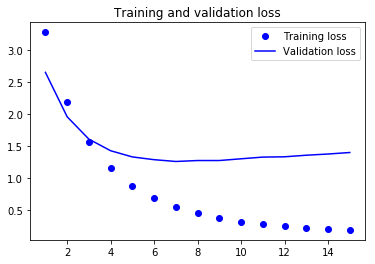

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [57]:
# load datasets
dataset = load_clean_sentences('english-german-both.pkl')
train = load_clean_sentences('english-german-train.pkl')
test = load_clean_sentences('english-german-test.pkl')

# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))
# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
print('German Vocabulary Size: %d' % ger_vocab_size)
print('German Max Length: %d' % (ger_length))

attention_trainX = encode_sequences(ger_tokenizer, max(ger_length, eng_length), train[:, 1])
attention_trainY = encode_sequences(eng_tokenizer, max(ger_length, eng_length), train[:, 0])
attention_trainY = encode_output(attention_trainY, eng_vocab_size)
attention_testX = encode_sequences(ger_tokenizer, max(ger_length, eng_length), test[:, 1])
attention_testY = encode_sequences(eng_tokenizer, max(ger_length, eng_length), test[:, 0])
attention_testY = encode_output(attention_testY, eng_vocab_size)

attention_model = define_attention_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 256)
attention_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# summarize defined model
print(attention_model.summary())
plot_model(model, to_file='model.png', show_shapes=True)

# fit model
filename = 'attention_model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = attention_model.fit(attention_trainX, attention_trainY, epochs=15, batch_size=64, validation_data=(attention_testX, attention_testY), callbacks=[checkpoint], verbose=2)

English Vocabulary Size: 3778
English Max Length: 6
German Vocabulary Size: 5830
German Max Length: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 10, 256)           1492480   
_________________________________________________________________
lstm_15 (LSTM)               (None, 10, 256)           525312    
_________________________________________________________________
AttentionDecoder (AttentionD (None, 10, 3778)          19704006  
Total params: 21,721,798
Trainable params: 21,721,798
Non-trainable params: 0
_________________________________________________________________
None
Train on 18000 samples, validate on 2000 samples
Epoch 1/15
 - 295s - loss: 4.8913 - acc: 0.2823 - val_loss: 4.0609 - val_acc: 0.3495

Epoch 00001: val_loss improved from inf to 4.06091, saving model to attention_model.h5
Epoch 2/15
 - 272s - loss: 3.6314 - acc: 0.3974 - val_loss: 3.40

In [ ]:
print(train[0])
print(trainX[0])

In [45]:
print(len(train))

48000


In [46]:
print(train[1])
print(trainX[1])

['the money disappeared' 'das geld verschwand']
[   4  119 2938    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]


## Evaluate the Model

In [10]:
from pickle import load
from numpy import array
from numpy import argmax
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction

In [11]:
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

In [12]:
# generate target given source sequence
def predict_sequence(model, tokenizer, source):
	prediction = model.predict(source, verbose=0)[0]
	integers = [argmax(vector) for vector in prediction]
	target = list()
	for i in integers:
		word = word_for_id(i, tokenizer)
		if word is None:
			break
		target.append(word)
	return ' '.join(target)

In [13]:
# evaluate the skill of the model
def evaluate_model(model, tokenizer, sources, raw_dataset):
  smoothie = SmoothingFunction().method4
  actual, predicted = list(), list()
  correct_num = 0
  total = 0
  for i, source in enumerate(sources):
    # translate encoded source text
    source = source.reshape((1, source.shape[0]))
    translation = predict_sequence(model, eng_tokenizer, source)
    raw_target, raw_src = raw_dataset[i]
    total += 1
    if translation == raw_target.lower():
      correct_num += 1
    if i < 10:
      print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
    actual.append(raw_target.split())
    predicted.append(translation.split())
	# calculate BLEU score
  print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0), smoothing_function=smoothie))
  print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie))
  print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0), smoothing_function=smoothie))
  print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie))
  # calculate accuracy
  print(float(correct_num / total))

In [62]:
# load model
model = load_model('model.h5')
# test on some training sequences
print('train')
evaluate_model(model, eng_tokenizer, trainX, train)
# test on some test sequences
print('test')
evaluate_model(model, eng_tokenizer, testX, test)

train
src=[ich habe es kaputtgemacht], target=[i broke it], predicted=[i broke it]
src=[sie konnte ihn nicht leiden], target=[she hated him], predicted=[she hates him]
src=[tom brachte mary um], target=[tom killed mary], predicted=[tom killed mary]
src=[du hast ihm weh getan], target=[you hurt him], predicted=[you made him]
src=[guckst du], target=[are you looking], predicted=[are you looking]
src=[ist dein name tom], target=[is your name tom], predicted=[is your name tom]
src=[ich kann tennis spielen], target=[i can play tennis], predicted=[i can play tennis]
src=[sie haben es verdient], target=[they deserved it], predicted=[they deserved it]
src=[sie kundigten], target=[they canceled], predicted=[they canceled]
src=[dieser eimer ist undicht], target=[this bucket leaks], predicted=[this bucket leaks]
BLEU-1: 0.069184
BLEU-2: 0.215754
BLEU-3: 0.301818
BLEU-4: 0.269355
0.6631666666666667
test
src=[er ist dj], target=[he is a dj], predicted=[hes a dj]
src=[sie bezwang ihn], target=[she d

In [ ]:
# load bidirectional model
bi_model = load_model('bi_model.h5')
print('train')
evaluate_model(bi_model, eng_tokenizer, bi_trainX, train)
# test on some test sequences
print('test')
evaluate_model(bi_model, eng_tokenizer, bi_testX, test)

train
src=[Ich habe einen Camion], target=[I have a truck], predicted=[i have a truck]
src=[Willst du nicht ins Bett], target=[Arent you going to bed], predicted=[dont you going to bed]
src=[Er ist kein gewohnlicher Mann], target=[He is no ordinary man], predicted=[he is no ordinary man]
src=[Ich kann Tom nicht einfach mit Nichtbeachtung strafen], target=[I cant just ignore Tom], predicted=[i cant just ignore tom]
src=[Wir duschten], target=[We took showers], predicted=[we took showers]
src=[Ich kann Montage nicht ausstehen], target=[I hate Mondays], predicted=[i hate mondays]
src=[Was haben sie gesagt], target=[What did they say], predicted=[what did you say]
src=[Bitte halten Sie mich auf dem Laufenden], target=[Please keep me updated], predicted=[please call me updated]
src=[Beschleunigen wir das etwas], target=[Lets hurry it up], predicted=[lets on it]
src=[Tom jubelte], target=[Tom was cheering], predicted=[tom cheered]
BLEU-1: 0.051148
BLEU-2: 0.190325
BLEU-3: 0.283781
BLEU-4: 0.

In [58]:
# load attention model
attention_model = load_model('attention_model.h5', custom_objects={'AttentionDecoder':AttentionDecoder})
print('train')
evaluate_model(attention_model, eng_tokenizer, attention_trainX, train)
# test on some test sequences
print('test')
evaluate_model(attention_model, eng_tokenizer, attention_testX, test)

train
src=[ich habe es kaputtgemacht], target=[i broke it], predicted=[i broke it]
src=[sie konnte ihn nicht leiden], target=[she hated him], predicted=[she hated him]
src=[tom brachte mary um], target=[tom killed mary], predicted=[tom killed mary]
src=[du hast ihm weh getan], target=[you hurt him], predicted=[you hurt him]
src=[guckst du], target=[are you looking], predicted=[are you bored]
src=[ist dein name tom], target=[is your name tom], predicted=[is your name tom]
src=[ich kann tennis spielen], target=[i can play tennis], predicted=[i can play tennis]
src=[sie haben es verdient], target=[they deserved it], predicted=[they deserved it]
src=[sie kundigten], target=[they canceled], predicted=[they canceled]
src=[dieser eimer ist undicht], target=[this bucket leaks], predicted=[this bucket leaks]
BLEU-1: 0.066425
BLEU-2: 0.213713
BLEU-3: 0.302634
BLEU-4: 0.270919
0.6168333333333333
test
src=[er ist dj], target=[he is a dj], predicted=[hes a dj]
src=[sie bezwang ihn], target=[she def

In [53]:
import pickle 

with open('ger_tokenizer.pickle', 'wb') as handle:
    pickle.dump(ger_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('eng_tokenizer.pickle', 'wb') as handle:
    pickle.dump(eng_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
